# Table of Contents

- [Initalize](#Initalize)
- [Goal](#Goal)
- [Wrangle](#Wrangle)
- [EDA](#Explore)
    - [Insightful](#Insightful)
- [Hypthosis Testing](#Hypthosis-Testing)
  - [Choosen Features](#Choosen-Features)
- [Modeling](#Modeling)
- [Results and Summary](#Results-&-Conclusion)
- [Next Steps](#Next-Steps)
- [Appendix](#Appendix)

In [1]:
# establishing environment
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wrangle import wrangle

import warnings
warnings.filterwarnings("ignore")

print('Initalized')

Initalized


# Goal
The goal of this project is to use Natural Language Processing (NLP) to predict whether a Facebook Ad is political or not. We will pull in the data.

# Pre-processing

Before we get started with the EDA there are a few things we need to do. First we need to pull in the data we'll use for analysis with the imported wrangle function, and then we will need to make some word objects from the data to conduct analysis on.

In [2]:
help(wrangle)

Help on function wrangle in module wrangle:

wrangle(facebook_data_csv_location)
    This function requires that you download and unzip the file from the link below. File size is over 3gigs
    https://www.propublica.org/datastore/dataset/political-advertisements-from-facebook 
    Once unzipped, use the file path in the fuction to:
    * Load the csv into a pandas dataframe
    * Drops the following columns - 'listbuilding_fundraising_proba', 'targetedness', 'targetings', 'targets', 
    'targeting', 'images', 'lang', 'thumbnail', 'html', 'page_id', 'suppressed', 'entities', 'lower_page', 'id', and 'political_probability'
    * Create a socio_political_fb column that is 'Political' if facebook believes that the ad is about soical or political topics (advert_by is not null), 
    and 'Not Political' if facebook does not (advert_by is null)
    * Combine the advertiser and paid_for_by columns, with a priority given to paid_for_by values into a advert_by column
    * If advert_by column 

In [ ]:
train, validate, test = wrangle('facebookads.csv')

In [ ]:
train.head()

In [ ]:
# create series objects for messages socio_political_fb values that is a string of words joined on spaces 

political_words = ' '.join(train[train.socio_political_fb==True].message)

# for javascript
not_political_words = ' '.join(train[train.socio_political_fb == False].message)

# both python and java script
all_words = ' '.join(train.message)

political_words

In [ ]:
# Then for each series remove any stand-alone characters to reduce noise
political_words = re.sub(r'\s.\s', '', political_words)
not_political_words = re.sub(r'\s.\s', '', not_political_words)
all_words = re.sub(r'\s.\s', '', all_words)

# Explore

Now that the data has been processed into more usable forms we can begin to explore the data for features we can use in building our models. We will create a wordcloud and frequency chat from the top 20 words used across both political and non-political messages, and then we will create a frequency chart and word cloud charts by combining the top 10 words used by both political and non-political ads into a single word list. From this, we gathered some [insight](#Insightful) into how we may refine our model.

[Table of Contents](#Table-of-Contents)

In [7]:
# For each socio_political_fb find out how many times each word happens and put that into a topic_freq obj.
all_freq = pd.Series(all_words.split()).value_counts()
political_freq = pd.Series(political_words.split()).value_counts()
not_political_freq = pd.Series(not_political_words.split()).value_counts()

political_freq.head(10)

need        21718
help        16648
trump       14213
today       13790
make        12837
right       12533
campaign    11608
people      11303
vote         9714
get          9292
dtype: int64

In [8]:
not_political_freq.head(10)

need       5477
help       5261
trump      4422
today      4155
people     4143
support    3828
make       3299
right      3034
sign       2756
not        2680
dtype: int64

In [9]:
# Combine all the series together into a single data frame to see the word count across all topics
word_counts = (pd.concat([all_freq, political_freq, not_political_freq], axis=1, sort=True)
               .set_axis(['all', 'political', 'not_political', ], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

all  political  not_political
000               2          0              2
00000             1          1              0
00972569215599    1          0              1
01               18         18              0
010l              1          0              1

In [10]:
# Top 10 words used by javascript
top10_political = word_counts['political'].sort_values(ascending=False).head(10)

# top 10 words by python
top10_notpolitical = word_counts['not_political'].sort_values(ascending=False).head(10)

# combines the lists together
top10_each = (list(top10_political.index) + list(top10_notpolitical.index))

# Create the new data frame where the index values match the top_10_each value
top10both = word_counts[word_counts.index.isin(top10_each)]

top10both

all  political  not_political
campaign  13305      11608           1698
get       10964       9292           1678
help      21904      16648           5261
make      16135      12837           3299
need      27197      21718           5477
not       10727       8050           2680
people    15447      11303           4143
right     15573      12533           3034
sign       8531       5771           2756
support   12613       8798           3828
today     17930      13790           4155
trump     18642      14213           4422
vote      10932       9714           1219

In [11]:
print(f'political words = {list(top10_political.index)}')
print(f'not political words = {list(top10_notpolitical.index)}')

political words = ['need', 'help', 'trump', 'today', 'make', 'right', 'campaign', 'people', 'vote', 'get']
not political words = ['need', 'help', 'trump', 'today', 'people', 'support', 'make', 'right', 'sign', 'not']


In [12]:
# Create a top 20 all_words df
top20_all_words = word_counts['all'].sort_values(ascending=False).head(20)

top20_all_words

need        27197
help        21904
trump       18642
today       17930
make        16135
right       15573
people      15447
campaign    13305
support     12613
take        11667
like        10986
fight       10969
get         10964
vote        10932
not         10727
time        10685
new          9899
donation     9714
back         9528
one          8965
Name: all, dtype: int32

### Word Clouds

(-0.5, 799.5, 799.5, -0.5)

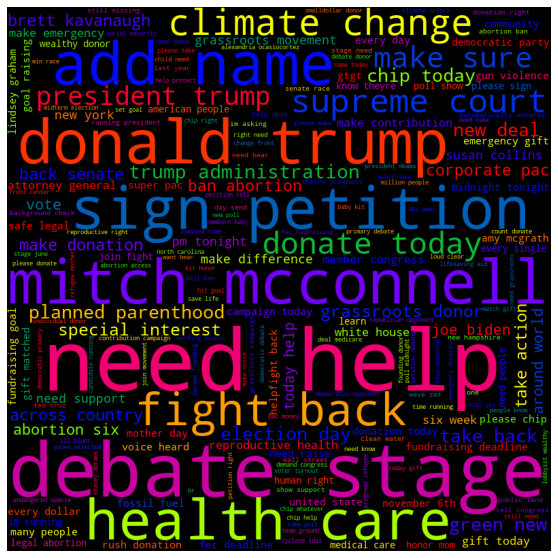

In [13]:
from wordcloud import WordCloud

plt.figure(figsize=(30,10))
political = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate(political_words)
plt.imshow(political)
plt.axis('off')

(-0.5, 799.5, 799.5, -0.5)

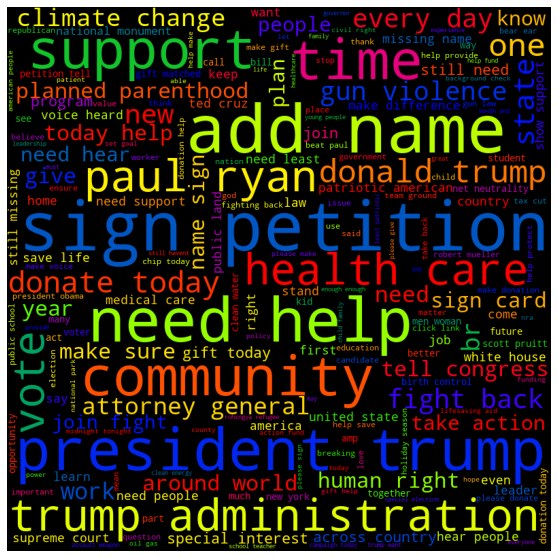

In [14]:
plt.figure(figsize=(30,10))
notpolitical = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate(not_political_words)
plt.imshow(notpolitical)
plt.axis('off')

(-0.5, 799.5, 799.5, -0.5)

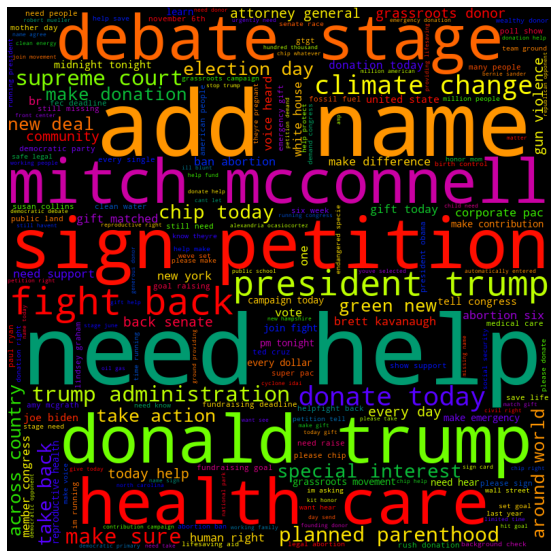

In [15]:
plt.figure(figsize=(30,10))
allwords = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate(all_words)
plt.imshow(allwords)
plt.axis('off')

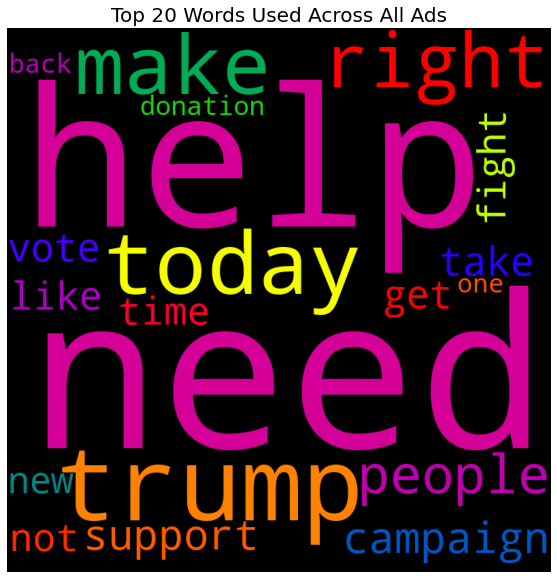

In [16]:
# Turn the dataframes into dictionaries
allz = {k: v for k, v in top20_all_words.to_dict().items()}

# Use the dictionary objects and .generate_from_frequencies method of WordCloud 
# to generate a wordcloud map for each language
all_top_20_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(allz)

plt.figure(figsize=(10,10))
plt.title("Top 20 Words Used Across All Ads", fontsize=20)
plt.imshow(all_top_20_cloud)
plt.axis('off')
plt.show()

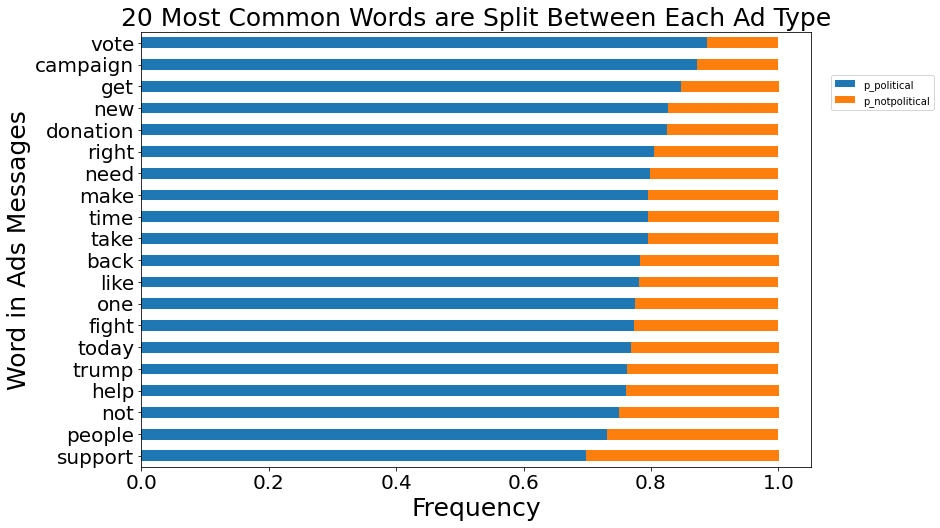

In [17]:
# visualize the percentage each coding language makes up for the top 20 words
(word_counts.assign(p_political = word_counts.political/word_counts['all'], 
                   p_notpolitical = word_counts.not_political/word_counts['all'])
 .sort_values(by='all')[['p_political', 'p_notpolitical']]
 .tail(20)
 .sort_values(by='p_political')
 .plot.barh(stacked=True, figsize=(12,8))
)
plt.title("20 Most Common Words are Split Between Each Ad Type", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Frequency', fontsize=25)
plt.ylabel('Word in Ads Messages', fontsize=25)
plt.legend(bbox_to_anchor=(1.03, .9),borderaxespad=0)
plt.show()

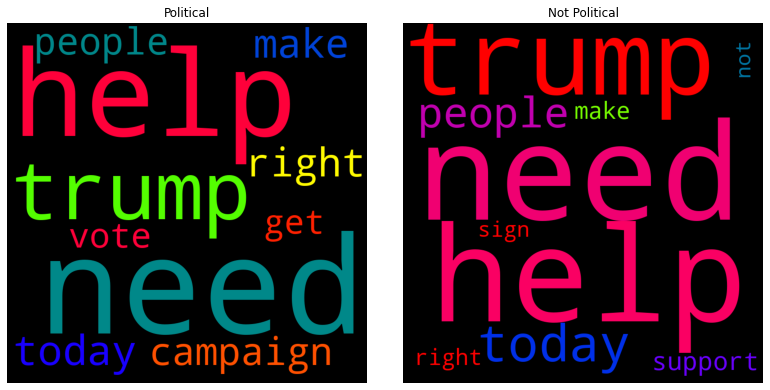

In [18]:
# Createa a top 10 words for each javascript and python
top10_political_words = word_counts['political'].sort_values(ascending=False).head(10)
top10_notpolitical_words = word_counts['not_political'].sort_values(ascending=False).head(10)

# Turn the dataframes into dictionaries
poli = {k: v for k, v in top10_political_words.to_dict().items()}
notpoli = {k: v for k, v in top10_notpolitical_words.to_dict().items()}


# Use the dictionary objects and .generate_from_frequencies method of WordCloud to generate a wordcloud map for each language
poli10_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(poli)

notpoli10_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(notpoli)

# Change the figure size
plt.figure(figsize=(10,10))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(poli10_cloud)
axs[1].imshow(notpoli10_cloud)

axs[0].set_title('Political')
axs[1].set_title('Not Political')

# Turn off the axis
for ax in axs: ax.axis('off')

# Insightful 

As you can see, there are only 13 words in our top10 each list and that is due to the fact that both political and not political messages contain **'need', 'help', 'trump', 'today', 'make', 'right', and people** in their top 10 lists. However, political ads represent over 60% of each words occurance within the corups. These may be words that we can add to our stop words list.

[Table of Contents](#Table-of-Contents)

<Figure size 1440x1008 with 0 Axes>

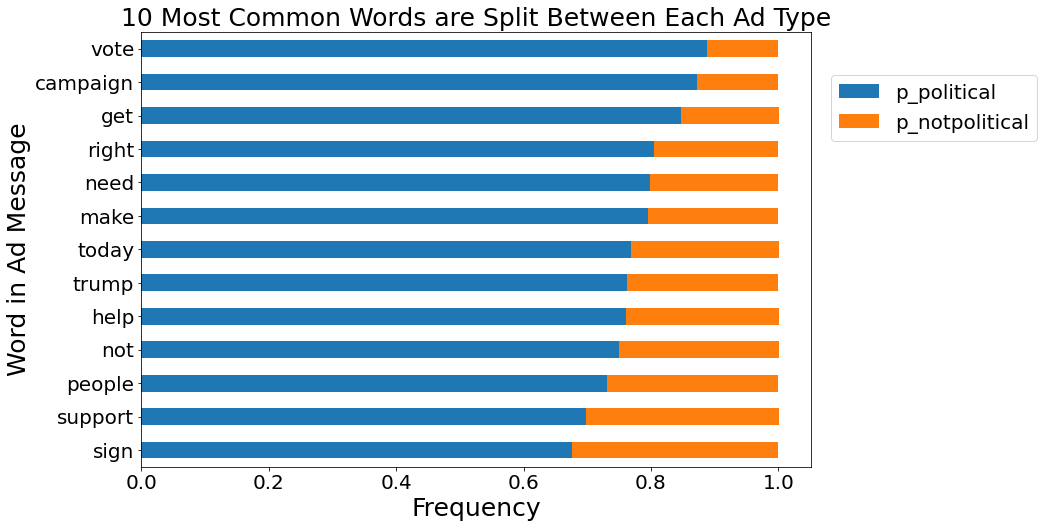

In [19]:
# visualize the percentage each coding language makes up for the top 10words of each Ad type
plt.figure(figsize=(20,14))
(top10both.assign(p_political = top10both.political/top10both['all'], 
                   p_notpolitical = top10both.not_political/top10both['all'])
 .sort_values(by='all')[['p_political', 'p_notpolitical']]
 .tail(20)
 .sort_values(by='p_political')
 .plot.barh(stacked=True, figsize=(12,8))
)

plt.title("10 Most Common Words are Split Between Each Ad Type", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Frequency', fontsize=25)
plt.ylabel('Word in Ad Message', fontsize=25)
plt.legend(bbox_to_anchor=(1.03, .9),borderaxespad=0, fontsize=20)
plt.show()

# Hypothesis Testing
[Table of Contents](#Table-of-Contents)


# Modeling

We'll now create various models that will make predictions about whether an ad is political or not based on the text within the ad's message.

We will use F1-score as our evaluation metric. The reason for using F1-score is because we want to correctly identify when an ad is in fact political in nature or not, and thus care equally about both falsly negatives and false positives results.

[Table of Contents](#Table-of-Contents)

In [20]:
# checking which language is most prominent
train.socio_political_fb.value_counts()

True     97498
False    35785
Name: socio_political_fb, dtype: int64

### Baseline Model - Train
- Always predicts political ad since that is the most common language

In [21]:
# setting baseline prediction to always be javascript
train['baseline_prediction'] = True

# printing performance metrics
print(classification_report(train.socio_political_fb, train.baseline_prediction))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00     35785
        True       0.73      1.00      0.84     97498

    accuracy                           0.73    133283
   macro avg       0.37      0.50      0.42    133283
weighted avg       0.54      0.73      0.62    133283



### Bag of Words Model - Train
- Logistic regression model
- Uses Bag-of-Words as sole feature
    - predicts language by counting how many times a word appears in each README

In [22]:
# setting target variable
y_train = train['socio_political_fb']

# creating vectorizer
vectorizer = CountVectorizer(stop_words='english', 
                             min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences. 
vectorizer.fit(train.message)

# Get dictionary. 
vectorizer.get_feature_names()

# Transform each sentences in vector space.
bow = vectorizer.transform(train.message)

X_bow = bow

# creating logistic regression object
lr_bag = LogisticRegression(random_state=123)

# fitting model to data
lr_bag = lr_bag.fit(X_bow, y_train)

train['bag_prediction'] = lr_bag.predict(X_bow)

print(classification_report(train.socio_political_fb, train.bag_prediction))

              precision    recall  f1-score   support

       False       0.89      0.63      0.74     35785
        True       0.88      0.97      0.92     97498

    accuracy                           0.88    133283
   macro avg       0.88      0.80      0.83    133283
weighted avg       0.88      0.88      0.87    133283



### TF-IDF Model - Train
- Logistic regression model
- Uses TF-IDF as sole feature
    - Weighs term frequency (TF), how often a term appears in a README and inverse document frequency (IDF), how important a term is, to predict programming language

In [23]:
# creating tfidf vectorizer
tfidf = TfidfVectorizer(stop_words='english', min_df = 20,
                             ngram_range=(1,2), 
                             binary=True)

# fitting and transforming readme data 
tfidf_sparse_matrix = tfidf.fit_transform(train.message)

# get vocabulary
tfidf.vocabulary_

# Transform to document-term matrix
vector_spaces = tfidf.transform(train.message)

X_tfidf = tfidf_sparse_matrix

# creating logistic regression object
lr_tfidf = LogisticRegression(random_state=123)

# fitting data model to data
lr_tfidf = lr_tfidf.fit(X_tfidf, y_train)

train['tfidf_prediction'] = lr_tfidf.predict(X_tfidf)

print(classification_report(train.socio_political_fb, train.tfidf_prediction))

              precision    recall  f1-score   support

       False       0.87      0.51      0.65     35785
        True       0.84      0.97      0.90     97498

    accuracy                           0.85    133283
   macro avg       0.86      0.74      0.77    133283
weighted avg       0.85      0.85      0.83    133283



## TRAIN MODELS EVALUATION

We'll use f1-score as our evaluation metric since we're false positive and false negativly identifying political adsare both equally important to the project.

- Baseline model performed with an accuracy score .84
- Bag of words performed with an accuracy score of .92
- TF-IDF model performed with an accuracy score of .90

Bag of Words and TF-IDF model had the highest accuracy scores, .92 and .90, respectively, so we're going to use them with our validate samples.

[Table of Contents](#Table-of-Contents)

### Bag of Words Model - Validate

In [24]:
# Transform each sentence in vector space.
v_bow = vectorizer.transform(validate.message)

# adding prediction column
validate['bag_prediction'] = lr_bag.predict(v_bow)

# printing evaluation metrics
print(classification_report(validate.socio_political_fb, validate.bag_prediction))

              precision    recall  f1-score   support

       False       0.79      0.55      0.65     11929
        True       0.85      0.95      0.90     32499

    accuracy                           0.84     44428
   macro avg       0.82      0.75      0.77     44428
weighted avg       0.83      0.84      0.83     44428



### TF-IDF Model - Validate

In [25]:
# transforming readme data
tfidf_sparse_matrix = tfidf.transform(validate.message)

# Transform to document-term matrix
vector_spaces = tfidf.transform(validate.message)

X_tfidf = tfidf_sparse_matrix

# adding prediction column
validate['tfidf_prediction'] = lr_tfidf.predict(X_tfidf)

# printing evaluation metrics
print(classification_report(validate.socio_political_fb, validate.tfidf_prediction))

              precision    recall  f1-score   support

       False       0.80      0.46      0.58     11929
        True       0.83      0.96      0.89     32499

    accuracy                           0.82     44428
   macro avg       0.82      0.71      0.74     44428
weighted avg       0.82      0.82      0.81     44428



### BoW Model - Test

As BoW model performed better than the TF-IDF model we'll use that on our test set. 

[Table of Contents](#Table-of-Contents)

In [26]:
# Transform each sentence in vector space.
v_bow = vectorizer.transform(test.message)

# adding prediction column
test['bag_prediction'] = lr_bag.predict(v_bow)

# printing evaluation metrics
print(classification_report(test.socio_political_fb, test.bag_prediction))

              precision    recall  f1-score   support

       False       0.79      0.55      0.65     11928
        True       0.85      0.95      0.90     32500

    accuracy                           0.84     44428
   macro avg       0.82      0.75      0.77     44428
weighted avg       0.83      0.84      0.83     44428



# Appendix

[Table of Contents](#Table-of-Contents)

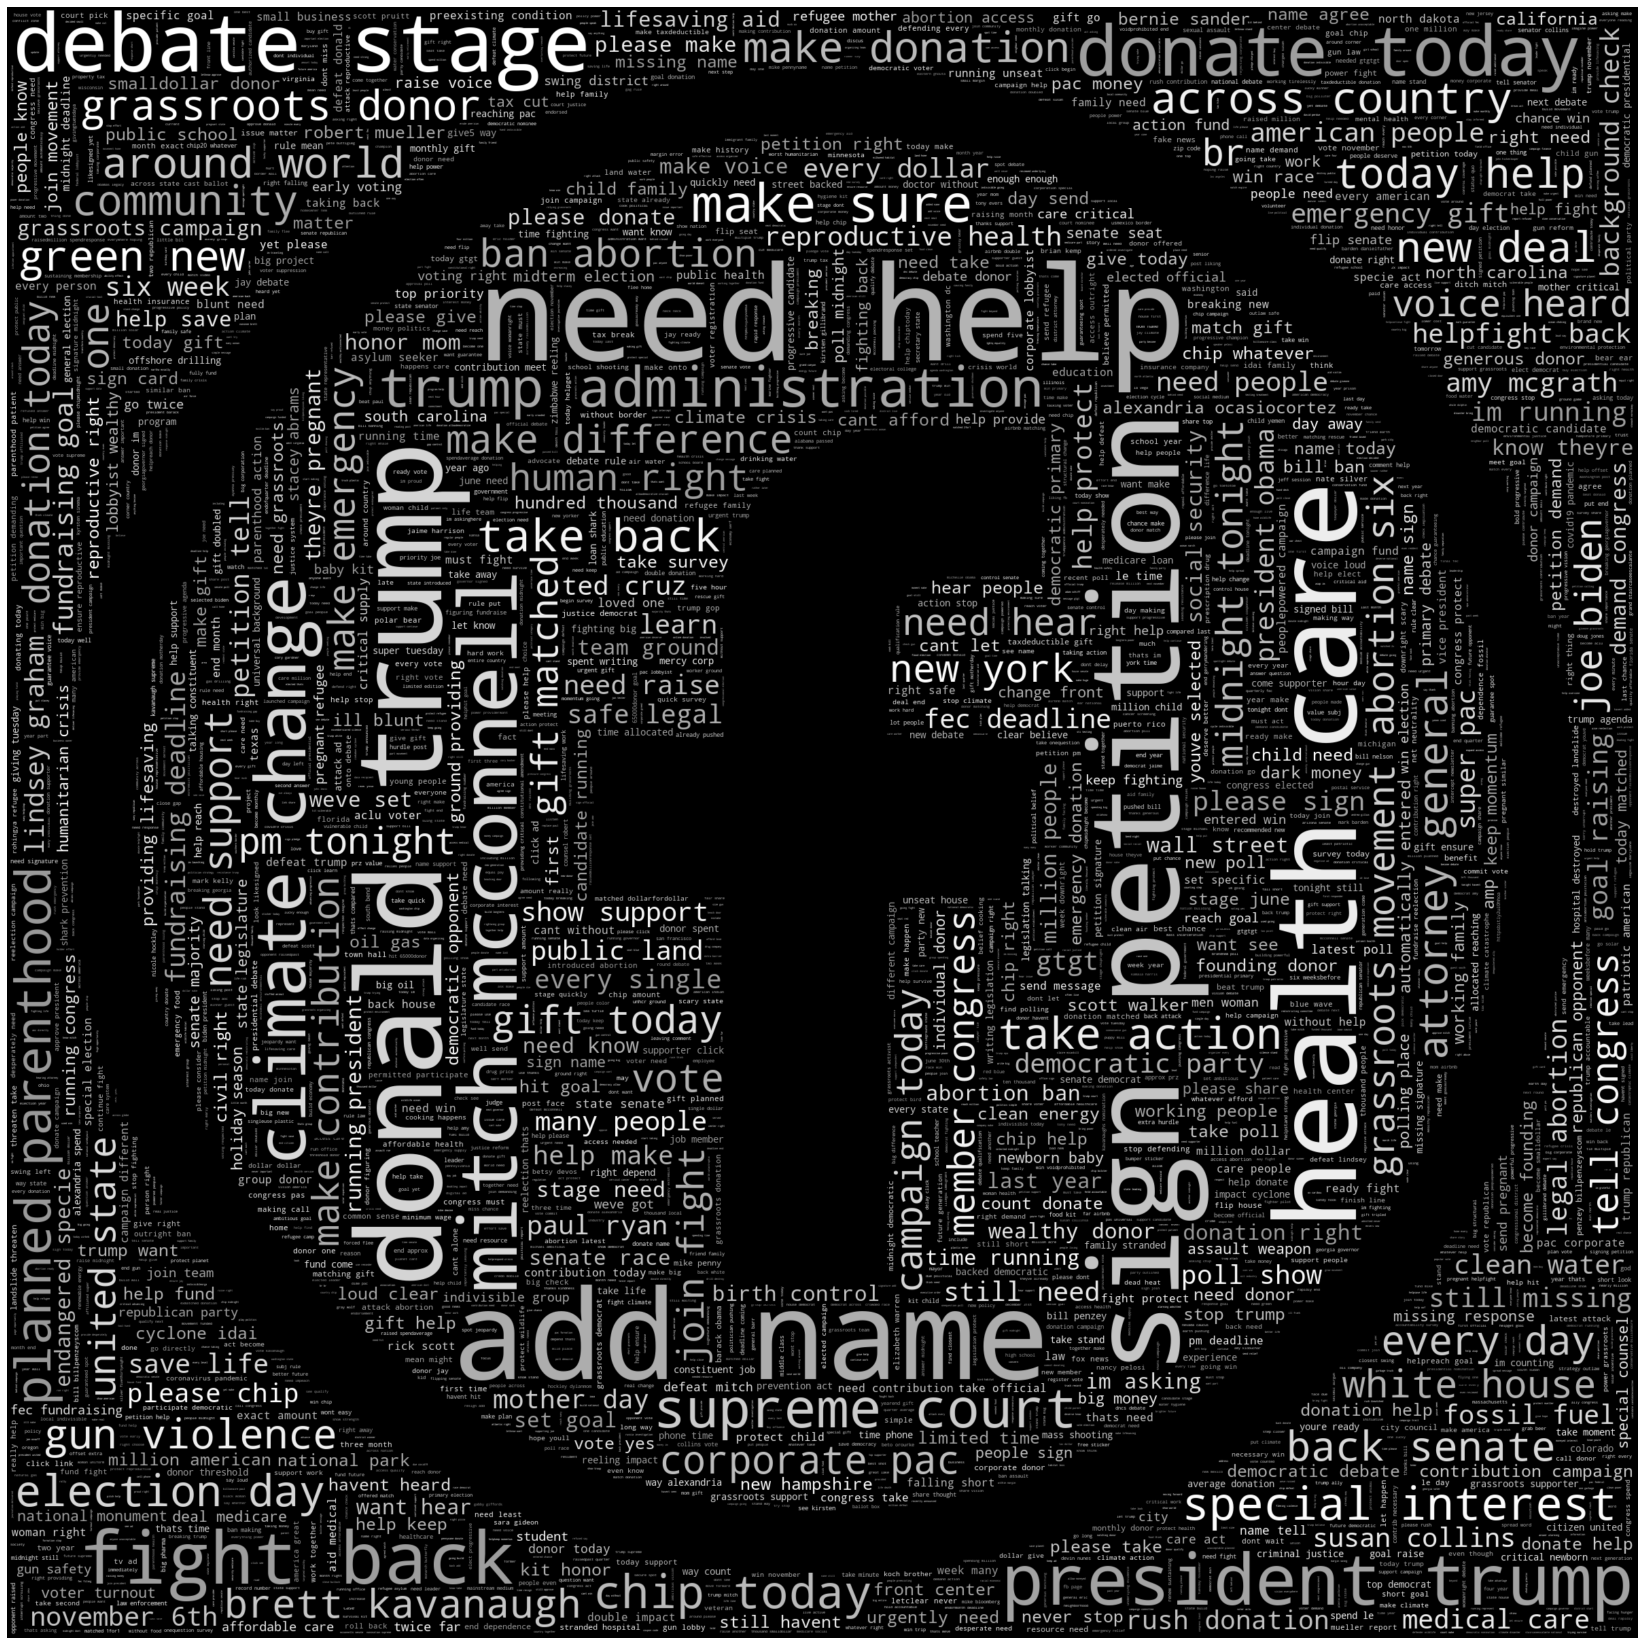

In [28]:
from PIL import Image
import random


mask = np.array(Image.open("images/fb.png"))

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

wc = WordCloud(max_words=3000, mask=mask, margin=10,
               random_state=1).generate(all_words)
# store default colored image
default_colors = wc.to_array()
plt.figure(figsize=(30,30))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
#wc.to_file("a_new_hope.png")
plt.axis("off")
plt.show()

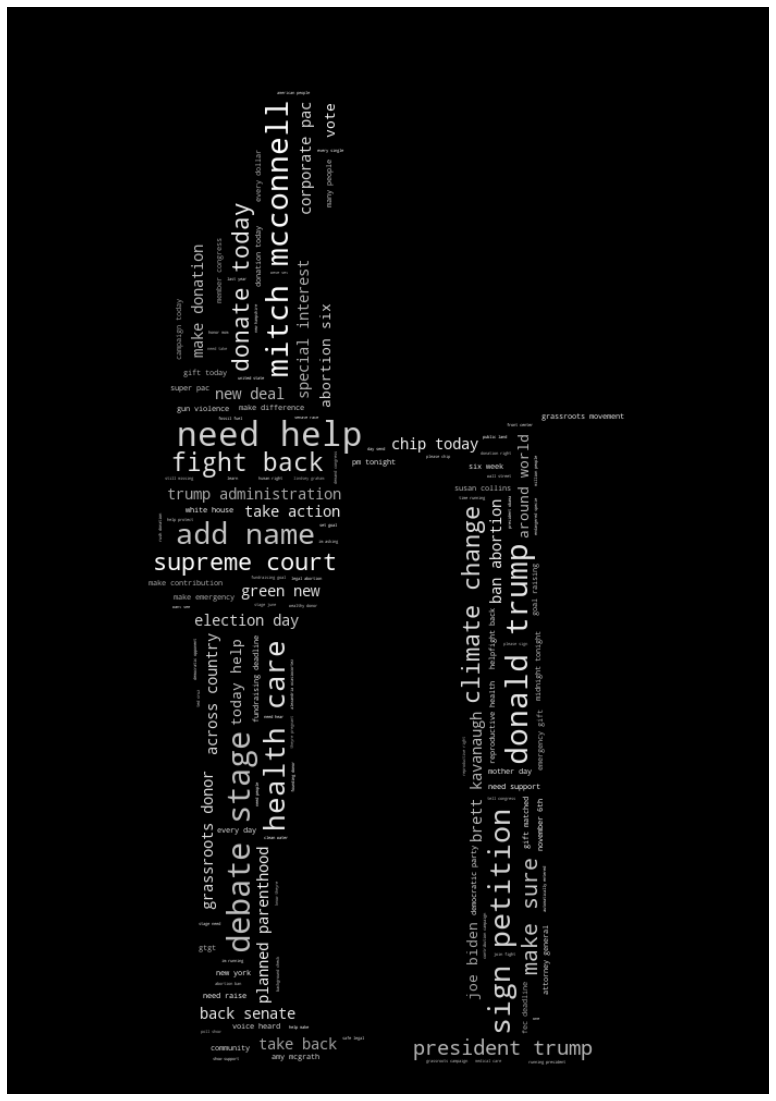

In [29]:
from PIL import Image
import random


mask = np.array(Image.open("images/test.jpg"))

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

wc = WordCloud(max_words=3000, mask=mask, margin=10,
               random_state=1).generate(political_words)
# store default colored image
default_colors = wc.to_array()
plt.figure(figsize=(20,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
#wc.to_file("a_new_hope.png")
plt.axis("off")
plt.show()

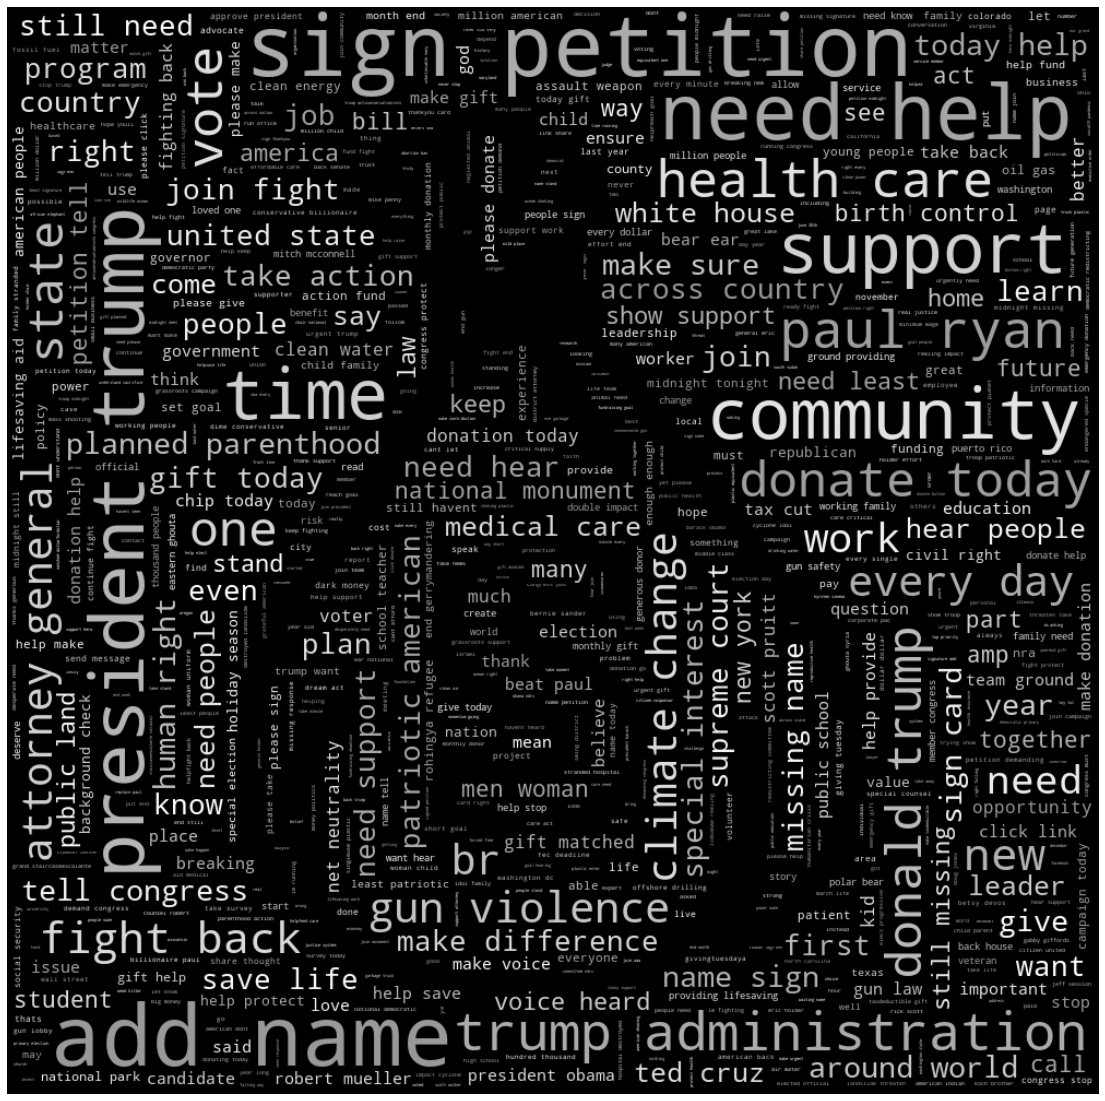

In [30]:
from PIL import Image
import random


mask = np.array(Image.open("images/moneybag.jpg"))

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

wc = WordCloud(max_words=3000, mask=mask, margin=10,
               random_state=1).generate(not_political_words)
# store default colored image
default_colors = wc.to_array()
plt.figure(figsize=(20,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
#wc.to_file("a_new_hope.png")
plt.axis("off")
plt.show()

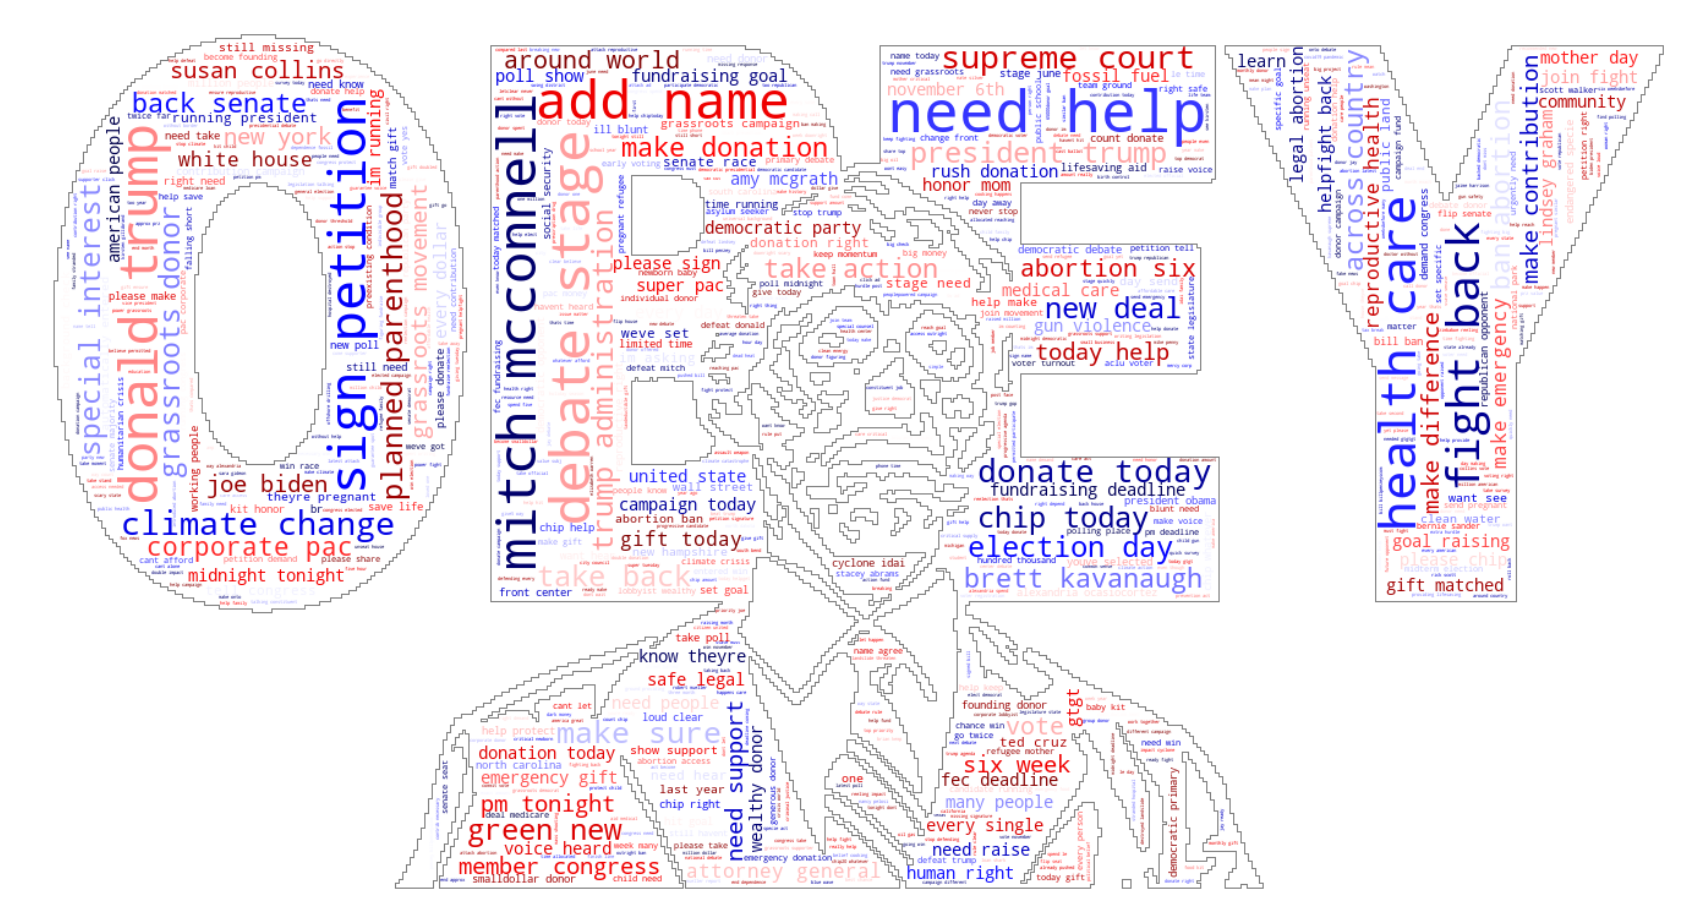

In [73]:
mask = np.array(Image.open("images/obey2.png"))

wc = WordCloud(background_color="white", max_words=1000, mask=mask, contour_width=.10, contour_color='gray', colormap='seismic')

# generate word cloud
wc.generate(political_words)

# show
plt.figure(figsize=(30,50))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()